In [54]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA


In [55]:
window = 20

file_path = './in/copper_log_returns_{}d_final.csv'.format(window)
df = pd.read_csv(file_path)
df

,Date,LMCADS03,LMCADY,DXY,SPX,BCOM,MXWD,XAU,XAG,LMCADY_acu_20d_log,LMCADY_std_20d_log
0,2003-01-02,0.019048,0.019834,0.010739,0.032661,0.025337,0.023209,-0.005763,0.007918,0.081352,0.009287
1,2003-01-03,0.013121,0.013478,-0.004965,-0.000484,0.014288,0.003782,0.014915,0.014833,0.075898,0.009074
2,2003-01-06,0.010804,0.010262,-0.004891,0.022226,-0.016118,0.018549,0.000000,0.001533,0.068538,0.008946
3,2003-01-07,-0.004616,-0.004479,0.005867,-0.006566,-0.002697,-0.008853,-0.011453,-0.020109,0.055772,0.009940
4,2003-01-08,0.009822,0.009771,-0.006848,-0.014186,0.004093,-0.014657,0.018206,0.010363,0.046443,0.009813
...,...,...,...,...,...,...,...,...,...,...,...
5530,2024-03-18,0.001872,0.001962,0.001449,0.006298,0.004918,0.005016,0.002067,-0.005957,0.055556,0.009941
5531,2024-03-19,-0.012455,-0.012914,0.002314,0.005633,-0.000881,0.002382,-0.001283,-0.004905,0.053156,0.010152
5532,2024-03-20,-0.005418,-0.005876,-0.004150,0.008865,-0.003435,0.006111,0.013260,0.026443,0.073317,0.010261
5533,2024-03-21,0.002517,0.002132,0.005979,0.003231,0.001955,0.006763,-0.002317,-0.033334,0.088143,0.010671


In [56]:
df['Date'] = pd.to_datetime(df['Date'])

df = df.sort_values(by='Date')

df = df.reset_index(drop=True)

targ = 'LMCADY_acu_{}d_log'.format(window)

time_series = df[targ]

In [57]:
if      window ==   5:
    test_size = 0.0050
elif    window ==   10:
    test_size = 0.0075
elif    window ==   20:
    test_size = 0.0100
    
LMCADY_train, LMCADY_test = train_test_split(time_series, test_size=test_size, shuffle=False)

In [58]:
def find_best_arima(time_series, max_q=20, best_p = 100):

    best_aic = float('inf')
    best_params = None

    for q in range(max_q + 1):
        try:
            model_arima = ARIMA(time_series, order=(best_p, 0, q))
            result_arima = model_arima.fit()

            aic = result_arima.aic
            print('ARIMA{} - AIC:{}'.format((best_p, 0, q), aic))

            if aic < best_aic:
                best_aic = aic
                best_params = (best_p, q)

        except Exception as e:
            continue

    return best_params, best_aic

In [59]:
if window == 5:
    best_p = 58 
elif window == 10:
    best_p = 59
elif window == 20:
    best_p = 100


# best_params, best_aic = find_best_arima(time_series,best_p=best_p)
# best_params, best_aic

# ((0, 5), -29830.06289218084)

best_params = (best_p, 10)
best_aic = -29830.06289218084

In [60]:
def evaluate_arima_model(train_series, test_series, p, q):

    if not isinstance(train_series.index, pd.DatetimeIndex):
        train_series.index = pd.RangeIndex(start=0, stop=len(train_series))

    predictions = []

    current_train = train_series.copy()

    for actual in test_series:
        model_arima = ARIMA(current_train, order=(p, 0, q))
        model_fit = model_arima.fit()

        prediction = model_fit.predict(start=len(current_train), end=(len(current_train)+window-1))
        print('Prediction array :,', prediction)
        print('Prediction: {:.6f}, real {:.6f}'.format(prediction.iloc[-1], actual))

        predictions.append(prediction.iloc[-1])

        current_train = pd.concat([current_train, pd.Series([actual], index=[len(current_train)])])

    return pd.Series(predictions, index=test_series.index)

In [61]:
def calculate_rmse(predictions, actual):
    if len(predictions) != len(actual):
        raise ValueError("Las predicciones y los valores reales deben tener la misma longitud.")

    mse = mean_squared_error(actual, predictions)
    rmse = np.sqrt(mse)
    return rmse

In [62]:
# p, q = best_params
p = 5
q = 5
print('p:', p, 'q:', q)

LMCADY_test_orig = LMCADY_test.copy()

LMCADY_test = LMCADY_test.shift(-window)
LMCADY_test.dropna(inplace=True)

LMCADY_predictions = evaluate_arima_model(LMCADY_train, LMCADY_test_orig, p, q)


p: 5 q: 5


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Prediction array :, 5479    0.007518
5480    0.007343
5481    0.007789
5482    0.008077
5483    0.007817
5484    0.008388
5485    0.008380
5486    0.008308
5487    0.008819
5488    0.008628
5489    0.008758
5490    0.009104
5491    0.008858
5492    0.009135
5493    0.009276
5494    0.009086
5495    0.009416
5496    0.009376
5497    0.009306
5498    0.009596
Name: predicted_mean, dtype: float64
Prediction: 0.009596, real 0.001594


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Prediction array :, 5480    0.002192
5481    0.002896
5482    0.002516
5483    0.002816
5484    0.003097
5485    0.002813
5486    0.003195
5487    0.003283
5488    0.003105
5489    0.003496
5490    0.003437
5491    0.003388
5492    0.003721
5493    0.003579
5494    0.003647
5495    0.003883
5496    0.003719
5497    0.003869
5498    0.003996
5499    0.003858
Name: predicted_mean, dtype: float64
Prediction: 0.003858, real -0.011147


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Prediction array :, 5481   -0.009265
5482   -0.008095
5483   -0.007393
5484   -0.006347
5485   -0.006106
5486   -0.005112
5487   -0.004441
5488   -0.004134
5489   -0.003155
5490   -0.002765
5491   -0.002328
5492   -0.001482
5493   -0.001266
5494   -0.000702
5495   -0.000063
5496    0.000096
5497    0.000727
5498    0.001145
5499    0.001339
5500    0.001953
Name: predicted_mean, dtype: float64
Prediction: 0.001953, real 0.003606


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Prediction array :, 5482    0.004142
5483    0.004831
5484    0.005282
5485    0.005525
5486    0.007218
5487    0.006990
5488    0.007762
5489    0.008951
5490    0.008627
5491    0.009704
5492    0.010348
5493    0.010168
5494    0.011323
5495    0.011508
5496    0.011600
5497    0.012621
5498    0.012513
5499    0.012886
5500    0.013633
5501    0.013419
Name: predicted_mean, dtype: float64
Prediction: 0.013419, real -0.008533


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Prediction array :, 5483   -0.006421
5484   -0.005883
5485   -0.003532
5486   -0.002393
5487   -0.002132
5488    0.000081
5489    0.000797
5490    0.001253
5491    0.003184
5492    0.003616
5493    0.004227
5494    0.005855
5495    0.006104
5496    0.006824
5497    0.008152
5498    0.008295
5499    0.009077
5500    0.010124
5501    0.010221
5502    0.011019
Name: predicted_mean, dtype: float64
Prediction: 0.011019, real -0.021678


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Prediction array :, 5484   -0.019442
5485   -0.018392
5486   -0.015737
5487   -0.015506
5488   -0.014482
5489   -0.012238
5490   -0.012416
5491   -0.010796
5492   -0.009344
5493   -0.009452
5494   -0.007566
5495   -0.006872
5496   -0.006622
5497   -0.004832
5498   -0.004677
5499   -0.003983
5500   -0.002569
5501   -0.002651
5502   -0.001609
5503   -0.000700
Name: predicted_mean, dtype: float64
Prediction: -0.000700, real -0.021607


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Prediction array :, 5485   -0.020558
5486   -0.017627
5487   -0.017674
5488   -0.016693
5489   -0.014376
5490   -0.014801
5491   -0.013178
5492   -0.011713
5493   -0.012051
5494   -0.010125
5495   -0.009472
5496   -0.009425
5497   -0.007566
5498   -0.007505
5499   -0.006972
5500   -0.005474
5501   -0.005699
5502   -0.004759
5503   -0.003773
5504   -0.003995
Name: predicted_mean, dtype: float64
Prediction: -0.003995, real -0.018927


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Prediction array :, 5486   -0.016482
5487   -0.016277
5488   -0.015305
5489   -0.013295
5490   -0.013327
5491   -0.011881
5492   -0.010529
5493   -0.010524
5494   -0.008851
5495   -0.008143
5496   -0.007854
5497   -0.006255
5498   -0.006013
5499   -0.005362
5500   -0.004073
5501   -0.004049
5502   -0.003109
5503   -0.002245
5504   -0.002206
5505   -0.001142
Name: predicted_mean, dtype: float64
Prediction: -0.001142, real -0.013700


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Prediction array :, 5487   -0.015436
5488   -0.013851
5489   -0.011731
5490   -0.012960
5491   -0.010820
5492   -0.009640
5493   -0.010332
5494   -0.008174
5495   -0.007636
5496   -0.007800
5497   -0.005851
5498   -0.005709
5499   -0.005431
5500   -0.003813
5501   -0.003863
5502   -0.003267
5503   -0.002018
5504   -0.002111
5505   -0.001332
5506   -0.000430
Name: predicted_mean, dtype: float64
Prediction: -0.000430, real -0.009495


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Prediction array :, 5488   -0.008481
5489   -0.006802
5490   -0.007386
5491   -0.005604
5492   -0.004661
5493   -0.004941
5494   -0.003026
5495   -0.002820
5496   -0.002563
5497   -0.000907
5498   -0.001116
5499   -0.000354
5500    0.000811
5501    0.000520
5502    0.001598
5503    0.002221
5504    0.002101
5505    0.003246
5506    0.003425
5507    0.003594
Name: predicted_mean, dtype: float64
Prediction: 0.003594, real -0.000097


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Prediction array :, 5489    0.000601
5490   -0.000555
5491    0.000247
5492    0.001216
5493    0.000556
5494    0.001574
5495    0.002020
5496    0.001581
5497    0.002691
5498    0.002692
5499    0.002582
5500    0.003576
5501    0.003299
5502    0.003516
5503    0.004257
5504    0.003881
5505    0.004344
5506    0.004777
5507    0.004451
5508    0.005040
Name: predicted_mean, dtype: float64
Prediction: 0.005040, real 0.016474


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Prediction array :, 5490    0.013402
5491    0.014325
5492    0.013264
5493    0.012999
5494    0.013587
5495    0.012590
5496    0.012504
5497    0.012871
5498    0.011955
5499    0.011993
5500    0.012172
5501    0.011361
5502    0.011474
5503    0.011500
5504    0.010804
5505    0.010954
5506    0.010861
5507    0.010281
5508    0.010439
5509    0.010261
Name: predicted_mean, dtype: float64
Prediction: 0.010261, real 0.011922


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Prediction array :, 5491    0.012270
5492    0.012228
5493    0.011292
5494    0.012541
5495    0.011575
5496    0.011440
5497    0.012269
5498    0.011130
5499    0.011570
5500    0.011826
5501    0.010865
5502    0.011593
5503    0.011316
5504    0.010752
5505    0.011462
5506    0.010837
5507    0.010719
5508    0.011185
5509    0.010455
5510    0.010689
Name: predicted_mean, dtype: float64
Prediction: 0.010689, real 0.013383


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Prediction array :, 5492    0.012954
5493    0.011515
5494    0.012992
5495    0.011787
5496    0.011219
5497    0.012219
5498    0.010846
5499    0.010873
5500    0.011329
5501    0.010077
5502    0.010441
5503    0.010409
5504    0.009443
5505    0.009912
5506    0.009528
5507    0.008900
5508    0.009302
5509    0.008727
5510    0.008405
5511    0.008644
Name: predicted_mean, dtype: float64
Prediction: 0.008644, real -0.001889


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Prediction array :, 5493   -0.001606
5494    0.000156
5495    0.000091
5496    0.000667
5497    0.001201
5498    0.001318
5499    0.001905
5500    0.002237
5501    0.002405
5502    0.002962
5503    0.003131
5504    0.003384
5505    0.003841
5506    0.003919
5507    0.004244
5508    0.004565
5509    0.004625
5510    0.004978
5511    0.005164
5512    0.005256
Name: predicted_mean, dtype: float64
Prediction: 0.005256, real 0.002592


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Prediction array :, 5494    0.004563
5495    0.004651
5496    0.004082
5497    0.004875
5498    0.005255
5499    0.004743
5500    0.005657
5501    0.005643
5502    0.005420
5503    0.006253
5504    0.005991
5505    0.006056
5506    0.006693
5507    0.006330
5508    0.006620
5509    0.007013
5510    0.006674
5511    0.007093
5512    0.007250
5513    0.007019
Name: predicted_mean, dtype: float64
Prediction: 0.007019, real 0.003185


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Prediction array :, 5495    0.003043
5496    0.003493
5497    0.003917
5498    0.004170
5499    0.004468
5500    0.004846
5501    0.005029
5502    0.005340
5503    0.005625
5504    0.005782
5505    0.006082
5506    0.006281
5507    0.006438
5508    0.006704
5509    0.006836
5510    0.007003
5511    0.007216
5512    0.007308
5513    0.007480
5514    0.007633
Name: predicted_mean, dtype: float64
Prediction: 0.007633, real -0.011120


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Prediction array :, 5496   -0.009374
5497   -0.008302
5498   -0.007213
5499   -0.006276
5500   -0.006048
5501   -0.004725
5502   -0.004255
5503   -0.003803
5504   -0.002641
5505   -0.002438
5506   -0.001767
5507   -0.000887
5508   -0.000776
5509    0.000031
5510    0.000595
5511    0.000755
5512    0.001574
5513    0.001870
5514    0.002154
5515    0.002868
Name: predicted_mean, dtype: float64
Prediction: 0.002868, real -0.016167


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Prediction array :, 5497   -0.014505
5498   -0.013131
5499   -0.011802
5500   -0.011313
5501   -0.010078
5502   -0.009081
5503   -0.008592
5504   -0.007357
5505   -0.006702
5506   -0.006105
5507   -0.005006
5508   -0.004582
5509   -0.003865
5510   -0.002990
5511   -0.002670
5512   -0.001883
5513   -0.001258
5514   -0.000937
5515   -0.000165
5516    0.000244
Name: predicted_mean, dtype: float64
Prediction: 0.000244, real -0.017295


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Prediction array :, 5498   -0.015601
5499   -0.014419
5500   -0.013258
5501   -0.011870
5502   -0.010981
5503   -0.009806
5504   -0.008672
5505   -0.007876
5506   -0.006757
5507   -0.005854
5508   -0.005099
5509   -0.004085
5510   -0.003368
5511   -0.002631
5512   -0.001758
5513   -0.001174
5514   -0.000459
5515    0.000259
5516    0.000761
5517    0.001434
Name: predicted_mean, dtype: float64
Prediction: 0.001434, real -0.002853


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Prediction array :, 5499   -0.002598
5500   -0.002695
5501   -0.002156
5502   -0.001810
5503   -0.000938
5504   -0.000806
5505   -0.000257
5506    0.000373
5507    0.000460
5508    0.001093
5509    0.001481
5510    0.001621
5511    0.002241
5512    0.002434
5513    0.002673
5514    0.003196
5515    0.003275
5516    0.003606
5517    0.003983
5518    0.004030
Name: predicted_mean, dtype: float64
Prediction: 0.004030, real 0.004962


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Prediction array :, 5500    0.004251
5501    0.004488
5502    0.004349
5503    0.004807
5504    0.005113
5505    0.004966
5506    0.005506
5507    0.005559
5508    0.005563
5509    0.006043
5510    0.005937
5511    0.006104
5512    0.006436
5513    0.006282
5514    0.006564
5515    0.006717
5516    0.006609
5517    0.006924
5518    0.006923
5519    0.006912
Name: predicted_mean, dtype: float64
Prediction: 0.006912, real 0.024987


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Prediction array :, 5501    0.023318
5502    0.022202
5503    0.021517
5504    0.020790
5505    0.020985
5506    0.019846
5507    0.019628
5508    0.019506
5509    0.018456
5510    0.018522
5511    0.018074
5512    0.017282
5513    0.017430
5514    0.016746
5515    0.016277
5516    0.016336
5517    0.015565
5518    0.015383
5519    0.015254
5520    0.014547
Name: predicted_mean, dtype: float64
Prediction: 0.014547, real 0.012879


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Prediction array :, 5502    0.012832
5503    0.012654
5504    0.012667
5505    0.013355
5506    0.012194
5507    0.012903
5508    0.012908
5509    0.012078
5510    0.012946
5511    0.012428
5512    0.012093
5513    0.012797
5514    0.012012
5515    0.012149
5516    0.012488
5517    0.011717
5518    0.012161
5519    0.012087
5520    0.011547
5521    0.012072
Name: predicted_mean, dtype: float64
Prediction: 0.012072, real 0.034231


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Prediction array :, 5503    0.033476
5504    0.033146
5505    0.028645
5506    0.029063
5507    0.029590
5508    0.025444
5509    0.026570
5510    0.025861
5511    0.022762
5512    0.023968
5513    0.022485
5514    0.020390
5515    0.021347
5516    0.019492
5517    0.018234
5518    0.018786
5519    0.016878
5520    0.016236
5521    0.016354
5522    0.014609
Name: predicted_mean, dtype: float64
Prediction: 0.014609, real 0.055508


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Prediction array :, 5504    0.051938
5505    0.049694
5506    0.045967
5507    0.045576
5508    0.043792
5509    0.040650
5510    0.040711
5511    0.038220
5512    0.036154
5513    0.036072
5514    0.033315
5515    0.032232
5516    0.031683
5517    0.029100
5518    0.028708
5519    0.027606
5520    0.025528
5521    0.025451
5522    0.023921
5523    0.022497
Name: predicted_mean, dtype: float64
Prediction: 0.022497, real 0.051029


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Prediction array :, 5505    0.049535
5506    0.046070
5507    0.045898
5508    0.044497
5509    0.041461
5510    0.041787
5511    0.039539
5512    0.037558
5513    0.037730
5514    0.035100
5515    0.034118
5516    0.033769
5517    0.031243
5518    0.030969
5519    0.029996
5520    0.027946
5521    0.027990
5522    0.026517
5523    0.025124
5524    0.025124
Name: predicted_mean, dtype: float64
Prediction: 0.025124, real 0.051661


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Prediction array :, 5506    0.047944
5507    0.047921
5508    0.046373
5509    0.043262
5510    0.043809
5511    0.041292
5512    0.039425
5513    0.039679
5514    0.036800
5515    0.036051
5516    0.035617
5517    0.032960
5518    0.032932
5519    0.031749
5520    0.029728
5521    0.029933
5522    0.028215
5523    0.026986
5524    0.027008
5525    0.025110
Name: predicted_mean, dtype: float64
Prediction: 0.025110, real 0.048489


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Prediction array :, 5507    0.048175
5508    0.046478
5509    0.043090
5510    0.043503
5511    0.040910
5512    0.038753
5513    0.038970
5514    0.035993
5515    0.034980
5516    0.034596
5517    0.031781
5518    0.031565
5519    0.030476
5520    0.028233
5521    0.028361
5522    0.026721
5523    0.025240
5524    0.025301
5525    0.023415
5526    0.022659
Name: predicted_mean, dtype: float64
Prediction: 0.022659, real 0.087053


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Prediction array :, 5508    0.082576
5509    0.078053
5510    0.076152
5511    0.071840
5512    0.070452
5513    0.067433
5514    0.064147
5515    0.062907
5516    0.059601
5517    0.057263
5518    0.055825
5519    0.052616
5520    0.051033
5521    0.049244
5522    0.046456
5523    0.045316
5524    0.043229
5525    0.041035
5526    0.040031
5527    0.037830
Name: predicted_mean, dtype: float64
Prediction: 0.037830, real 0.065911


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Prediction array :, 5509    0.062741
5510    0.061301
5511    0.058207
5512    0.057305
5513    0.054013
5514    0.052204
5515    0.050851
5516    0.047803
5517    0.046624
5518    0.044858
5519    0.042311
5520    0.041440
5521    0.039381
5522    0.037447
5523    0.036602
5524    0.034466
5525    0.033102
5526    0.032111
5527    0.030116
5528    0.029176
Name: predicted_mean, dtype: float64
Prediction: 0.029176, real 0.064397


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Prediction array :, 5510    0.062876
5511    0.059552
5512    0.058528
5513    0.055003
5514    0.053230
5515    0.051677
5516    0.048518
5517    0.047360
5518    0.045398
5519    0.042831
5520    0.041943
5521    0.039728
5522    0.037829
5523    0.036929
5524    0.034694
5525    0.033385
5526    0.032313
5527    0.030282
5528    0.029387
5529    0.028116
Name: predicted_mean, dtype: float64
Prediction: 0.028116, real 0.072999


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Prediction array :, 5511    0.068755
5512    0.067233
5513    0.063048
5514    0.060776
5515    0.059327
5516    0.055305
5517    0.054015
5518    0.051932
5519    0.048620
5520    0.047793
5521    0.045248
5522    0.042817
5523    0.042027
5524    0.039328
5525    0.037723
5526    0.036700
5527    0.034173
5528    0.033177
5529    0.031839
5530    0.029726
Name: predicted_mean, dtype: float64
Prediction: 0.029726, real 0.051683


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Prediction array :, 5512    0.052575
5513    0.048940
5514    0.051832
5515    0.049389
5516    0.045884
5517    0.048552
5518    0.045160
5519    0.043323
5520    0.044981
5521    0.041439
5522    0.040772
5523    0.041399
5524    0.038164
5525    0.038201
5526    0.037946
5527    0.035271
5528    0.035619
5529    0.034720
5530    0.032688
5531    0.033060
Name: predicted_mean, dtype: float64
Prediction: 0.033060, real 0.041955


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Prediction array :, 5513    0.039607
5514    0.039016
5515    0.038896
5516    0.035070
5517    0.035176
5518    0.034009
5519    0.030977
5520    0.031546
5521    0.029492
5522    0.027550
5523    0.027976
5524    0.025504
5525    0.024592
5526    0.024501
5527    0.022103
5528    0.021928
5529    0.021211
5530    0.019261
5531    0.019434
5532    0.018207
Name: predicted_mean, dtype: float64
Prediction: 0.018207, real 0.039015


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Prediction array :, 5514    0.038530
5515    0.038616
5516    0.034936
5517    0.035146
5518    0.034124
5519    0.031218
5520    0.031884
5521    0.029959
5522    0.028121
5523    0.028640
5524    0.026279
5525    0.025456
5526    0.025449
5527    0.023145
5528    0.023047
5529    0.022405
5530    0.020537
5531    0.020775
5532    0.019614
5533    0.018368
Name: predicted_mean, dtype: float64
Prediction: 0.018368, real 0.032623


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Prediction array :, 5515    0.032573
5516    0.028973
5517    0.029538
5518    0.028007
5519    0.024986
5520    0.025869
5521    0.023538
5522    0.021678
5523    0.022279
5524    0.019640
5525    0.018789
5526    0.018839
5527    0.016320
5528    0.016183
5529    0.015623
5530    0.013536
5531    0.013767
5532    0.012705
5533    0.011206
5534    0.011494
Name: predicted_mean, dtype: float64
Prediction: 0.011494, real 0.046287


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Prediction array :, 5516    0.041732
5517    0.041647
5518    0.040076
5519    0.036369
5520    0.037625
5521    0.034642
5522    0.032615
5523    0.033377
5524    0.029967
5525    0.029348
5526    0.029183
5527    0.026070
5528    0.026332
5529    0.025209
5530    0.022878
5531    0.023421
5532    0.021617
5533    0.020242
5534    0.020572
5535    0.018515
Name: predicted_mean, dtype: float64
Prediction: 0.018515, real 0.043598


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Prediction array :, 5517    0.043405
5518    0.041763
5519    0.038066
5520    0.039286
5521    0.036367
5522    0.034290
5523    0.035060
5524    0.031700
5525    0.031012
5526    0.030896
5527    0.027797
5528    0.028001
5529    0.026951
5530    0.024592
5531    0.025107
5532    0.023376
5533    0.021941
5534    0.022285
5535    0.020276
5536    0.019675
Name: predicted_mean, dtype: float64
Prediction: 0.019675, real 0.045582


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Prediction array :, 5518    0.043553
5519    0.039917
5520    0.041087
5521    0.038016
5522    0.036133
5523    0.036753
5524    0.033389
5525    0.032817
5526    0.032563
5527    0.029542
5528    0.029778
5529    0.028647
5530    0.026388
5531    0.026881
5532    0.025136
5533    0.023778
5534    0.024085
5535    0.022109
5536    0.021547
5537    0.021417
Name: predicted_mean, dtype: float64
Prediction: 0.021417, real 0.042529


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Prediction array :, 5519    0.039064
5520    0.040129
5521    0.037161
5522    0.035334
5523    0.035782
5524    0.032562
5525    0.031941
5526    0.031566
5527    0.028674
5528    0.028793
5529    0.027601
5530    0.025431
5531    0.025771
5532    0.024019
5533    0.022695
5534    0.022847
5535    0.020904
5536    0.020318
5537    0.020056
5538    0.018272
Name: predicted_mean, dtype: float64
Prediction: 0.018272, real 0.040804


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Prediction array :, 5520    0.042097
5521    0.038766
5522    0.036906
5523    0.037534
5524    0.034053
5525    0.033501
5526    0.033166
5527    0.030052
5528    0.030298
5529    0.029017
5530    0.026719
5531    0.027168
5532    0.025256
5533    0.023900
5534    0.024093
5535    0.021982
5536    0.021429
5537    0.021129
5538    0.019217
5539    0.019168
Name: predicted_mean, dtype: float64
Prediction: 0.019168, real 0.036073


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Prediction array :, 5521    0.033473
5522    0.031599
5523    0.032241
5524    0.029192
5525    0.028238
5526    0.028254
5527    0.025306
5528    0.025277
5529    0.024460
5530    0.022107
5531    0.022486
5532    0.021008
5533    0.019470
5534    0.019801
5535    0.017995
5536    0.017244
5537    0.017230
5538    0.015457
5539    0.015287
5540    0.014827
Name: predicted_mean, dtype: float64
Prediction: 0.014827, real 0.056388


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Prediction array :, 5522    0.053128
5523    0.052265
5524    0.044594
5525    0.045496
5526    0.043235
5527    0.037278
5528    0.038325
5529    0.035379
5530    0.030908
5531    0.031820
5532    0.028555
5533    0.025343
5534    0.025954
5535    0.022663
5536    0.020460
5537    0.020707
5538    0.017597
5539    0.016162
5540    0.016051
5541    0.013257
Name: predicted_mean, dtype: float64
Prediction: 0.013257, real 0.075604


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Prediction array :, 5523    0.073142
5524    0.067396
5525    0.064087
5526    0.063584
5527    0.058874
5528    0.056787
5529    0.055611
5530    0.051198
5531    0.050180
5532    0.048177
5533    0.044557
5534    0.044041
5535    0.041418
5536    0.038797
5537    0.038297
5538    0.035416
5539    0.033745
5540    0.032949
5541    0.030190
5542    0.029238
Name: predicted_mean, dtype: float64
Prediction: 0.029238, real 0.078244


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Prediction array :, 5524    0.072140
5525    0.068730
5526    0.067934
5527    0.063111
5528    0.061244
5529    0.059636
5530    0.055317
5531    0.054370
5532    0.051978
5533    0.048576
5534    0.047971
5535    0.045075
5536    0.042713
5537    0.041991
5538    0.038992
5539    0.037536
5540    0.036448
5541    0.033720
5542    0.032882
5543    0.031393
Name: predicted_mean, dtype: float64
Prediction: 0.031393, real 0.081560


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Prediction array :, 5525    0.079657
5526    0.078372
5527    0.070957
5528    0.071053
5529    0.069038
5530    0.063091
5531    0.063563
5532    0.060922
5533    0.056369
5534    0.056886
5535    0.053938
5536    0.050585
5537    0.050955
5538    0.047954
5539    0.045580
5540    0.045706
5541    0.042841
5542    0.041228
5543    0.041085
5544    0.038480
Name: predicted_mean, dtype: float64
Prediction: 0.038480, real 0.080965


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Prediction array :, 5526    0.078914
5527    0.070870
5528    0.070625
5529    0.067773
5530    0.061376
5531    0.061431
5532    0.058178
5533    0.053213
5534    0.053320
5535    0.049927
5536    0.046174
5537    0.046184
5538    0.042854
5539    0.040087
5540    0.039924
5541    0.036801
5542    0.034809
5543    0.034453
5544    0.031630
5545    0.030224
Name: predicted_mean, dtype: float64
Prediction: 0.030224, real 0.081003


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Prediction array :, 5527    0.075212
5528    0.072944
5529    0.071223
5530    0.066197
5531    0.065142
5532    0.062604
5533    0.058652
5534    0.058095
5535    0.055020
5536    0.052263
5537    0.051691
5538    0.048473
5539    0.046781
5540    0.045888
5541    0.042911
5542    0.041992
5543    0.040688
5544    0.038227
5545    0.037736
5546    0.036106
Name: predicted_mean, dtype: float64
Prediction: 0.036106, real 0.045044


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Prediction array :, 5528    0.047302
5529    0.045404
5530    0.042706
5531    0.041345
5532    0.039720
5533    0.037345
5534    0.036200
5535    0.034602
5536    0.032593
5537    0.031593
5538    0.030066
5539    0.028383
5540    0.027490
5541    0.026062
5542    0.024664
5543    0.023853
5544    0.022546
5545    0.021390
5546    0.020647
5547    0.019472
Name: predicted_mean, dtype: float64
Prediction: 0.019472, real 0.047432


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Prediction array :, 5529    0.044542
5530    0.040091
5531    0.037782
5532    0.034074
5533    0.030605
5534    0.028250
5535    0.024756
5536    0.021818
5537    0.019513
5538    0.016304
5539    0.013814
5540    0.011575
5541    0.008713
5542    0.006586
5543    0.004450
5544    0.001958
5545    0.000125
5546   -0.001870
5547   -0.003996
5548   -0.005587
Name: predicted_mean, dtype: float64
Prediction: -0.005587, real 0.039859


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Prediction array :, 5530    0.036253
5531    0.036779
5532    0.034669
5533    0.032118
5534    0.031321
5535    0.029365
5536    0.027270
5537    0.026474
5538    0.024470
5539    0.022859
5540    0.021972
5541    0.020079
5542    0.018842
5543    0.017865
5544    0.016180
5545    0.015209
5546    0.014178
5547    0.012748
5548    0.011955
5549    0.010924
Name: predicted_mean, dtype: float64
Prediction: 0.010924, real 0.055556


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Prediction array :, 5531    0.053720
5532    0.050129
5533    0.047664
5534    0.045869
5535    0.043696
5536    0.041384
5537    0.039887
5538    0.037736
5539    0.035896
5540    0.034484
5541    0.032483
5542    0.031039
5543    0.029642
5544    0.027885
5545    0.026724
5546    0.025338
5547    0.023877
5548    0.022886
5549    0.021552
5550    0.020384
Name: predicted_mean, dtype: float64
Prediction: 0.020384, real 0.053156


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Prediction array :, 5532    0.049668
5533    0.047256
5534    0.045519
5535    0.043395
5536    0.041122
5537    0.039693
5538    0.037585
5539    0.035797
5540    0.034452
5541    0.032492
5542    0.031108
5543    0.029772
5544    0.028058
5545    0.026962
5546    0.025627
5547    0.024211
5548    0.023285
5549    0.021993
5550    0.020876
5551    0.020028
Name: predicted_mean, dtype: float64
Prediction: 0.020028, real 0.073317


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Prediction array :, 5533    0.068540
5534    0.065705
5535    0.061976
5536    0.058572
5537    0.057337
5538    0.053146
5539    0.051064
5540    0.049332
5541    0.045571
5542    0.044314
5543    0.042065
5544    0.039069
5545    0.038169
5546    0.035601
5547    0.033470
5548    0.032549
5549    0.029968
5550    0.028590
5551    0.027439
5552    0.025137
Name: predicted_mean, dtype: float64
Prediction: 0.025137, real 0.088143
Prediction array :, 5534    0.084348
5535    0.079009
5536    0.074463
5537    0.074225
5538    0.069734
5539    0.066033
5540    0.065407
5541    0.060928
5542    0.058145
5543    0.057048
5544    0.052845
5545    0.050735
5546    0.049240
5547    0.045459
5548    0.043815
5549    0.042032
5550    0.038743
5551    0.037399
5552    0.035448
5553    0.032664
Name: predicted_mean, dtype: float64
Prediction: 0.032664, real 0.112357


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [63]:
LMCADY_predictions = LMCADY_predictions[:-window]
LMCADY_rmse = calculate_rmse(LMCADY_predictions, LMCADY_test)

In [64]:
def plot_predictions(test_series, predictions, title, best_lags = "", markersize=3):
    plt.figure(figsize=(14, 3))

    plt.plot(test_series.index, test_series, label="Actual", marker='o', linestyle='-', markersize=markersize)
    plt.plot(test_series.index, predictions, label="Predicted", marker='x', linestyle='--', markersize=markersize)
    plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.7)


    plt.title(f"ARMA Model: {title}")
    plt.legend()
    plt.show()

In [65]:
LMCADY_rmse

0.04738723281432963

In [66]:
LMCADY_test.describe()['std']

0.022240983010212483

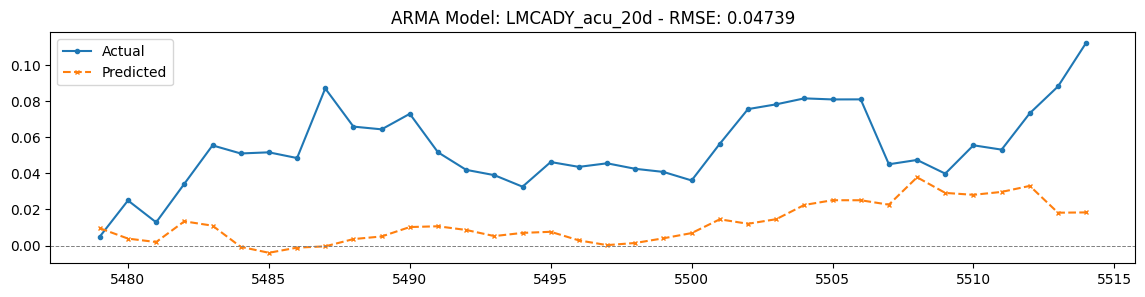

In [67]:
plot_predictions(LMCADY_test, LMCADY_predictions, "LMCADY_acu_{}d - RMSE: {:.5f}".format(window, LMCADY_rmse))